# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 topics most highly correlated with Investment growth (out of 200 topics estimated on articles published before 2008 using all sources). I forecast Investment growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 topics (<=2007, 200 topics, all sources).
- **Forecast Target:** Investment growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Hard+Surveys Factors:** 1 to 2
  - **Number of Text Factors:** 1
  - **Factor Order:** 1 to 3

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function_update

# Define inputs common to all models
q_var = 'Investment'                      # quarterly variable being forecasted
additional_factors = 'HardSurveys+Text'   # switch to separate factors scenario
start = '1991-04'
text_type = "topics"
estimation_period = "2007"
num_topics = "200"
source = "all"
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual_update.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of HardSurveys factors (1 or 2) and factor order values from 1 to 3
for num_factors in range(1, 3):  # 1 or 2 HardSurveys factors
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'HardSurveys': num_factors, 'Text': 1}
        factor_orders = {'HardSurveys': order, 'Text': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function_update.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function_update.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with HardSurveys factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = f"HS_{num_factors}_{order}"
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11426
EM converged at iteration 56, llf=-11201, convergence criterion=9.9355e-07 < tolerance=1e-06
EM start iterations, llf=-11439
EM converged at iteration 56, llf=-11214, convergence criterion=9.9685e-07 < tolerance=1e-06
EM start iterations, llf=-11491
EM converged at iteration 57, llf=-11262, convergence criterion=9.73e-07 < tolerance=1e-06
EM start iterations, llf=-11497
EM converged at iteration 57, llf=-11269, convergence criterion=9.7103e-07 < tolerance=1e-06
EM start iterations, llf=-11561
EM converged at iteration 55, llf=-11327, convergence criterion=9.9453e-07 < tolerance=1e-06
EM start iterations, llf=-11569
EM converged at iteration 55, llf=-11334, convergence criterion=9.8466e-07 < tolerance=1e-06
EM start iterations, llf=-11621
EM converged at iteration 55, llf=-11388, convergence criterion=9.7884e-07 < tolerance=1e-06
EM start iterations, llf=-11621
EM converged at iteration 55, llf=-11388, convergence criterion=9.7884e-07 < tolerance=1e-06
EM

EM start iterations, llf=-13002
EM converged at iteration 35, llf=-12833, convergence criterion=9.8951e-07 < tolerance=1e-06
EM start iterations, llf=-13065
EM converged at iteration 33, llf=-12906, convergence criterion=9.608e-07 < tolerance=1e-06
EM start iterations, llf=-13072
EM converged at iteration 35, llf=-12910, convergence criterion=9.7792e-07 < tolerance=1e-06
EM start iterations, llf=-13124
EM converged at iteration 36, llf=-12957, convergence criterion=9.6686e-07 < tolerance=1e-06
EM start iterations, llf=-13124
EM converged at iteration 36, llf=-12957, convergence criterion=9.6686e-07 < tolerance=1e-06
EM start iterations, llf=-13135
EM converged at iteration 37, llf=-12970, convergence criterion=9.5789e-07 < tolerance=1e-06
EM start iterations, llf=-13187
EM converged at iteration 36, llf=-13024, convergence criterion=9.875e-07 < tolerance=1e-06
EM start iterations, llf=-13193
EM converged at iteration 37, llf=-13028, convergence criterion=9.6643e-07 < tolerance=1e-06
EM

EM start iterations, llf=-14694
EM converged at iteration 36, llf=-14515, convergence criterion=9.7665e-07 < tolerance=1e-06
EM start iterations, llf=-14694
EM converged at iteration 36, llf=-14515, convergence criterion=9.7665e-07 < tolerance=1e-06
EM start iterations, llf=-14703
EM converged at iteration 36, llf=-14524, convergence criterion=9.7548e-07 < tolerance=1e-06
EM start iterations, llf=-14755
EM converged at iteration 36, llf=-14576, convergence criterion=9.613e-07 < tolerance=1e-06
EM start iterations, llf=-14766
EM converged at iteration 36, llf=-14587, convergence criterion=9.5398e-07 < tolerance=1e-06
EM start iterations, llf=-14816
EM converged at iteration 36, llf=-14637, convergence criterion=9.4317e-07 < tolerance=1e-06
EM start iterations, llf=-14823
EM converged at iteration 36, llf=-14644, convergence criterion=9.309e-07 < tolerance=1e-06
EM start iterations, llf=-14870
EM converged at iteration 35, llf=-14689, convergence criterion=9.8939e-07 < tolerance=1e-06
EM

EM start iterations, llf=-16375
EM converged at iteration 32, llf=-16167, convergence criterion=9.3154e-07 < tolerance=1e-06
EM start iterations, llf=-16380
EM converged at iteration 32, llf=-16172, convergence criterion=9.3193e-07 < tolerance=1e-06
EM start iterations, llf=-16432
EM converged at iteration 32, llf=-16224, convergence criterion=9.1387e-07 < tolerance=1e-06
EM start iterations, llf=-16439
EM converged at iteration 32, llf=-16230, convergence criterion=9.216e-07 < tolerance=1e-06
EM start iterations, llf=-16494
EM converged at iteration 32, llf=-16285, convergence criterion=9.1476e-07 < tolerance=1e-06
EM start iterations, llf=-16494
EM converged at iteration 32, llf=-16285, convergence criterion=9.1476e-07 < tolerance=1e-06
EM start iterations, llf=-16503
EM converged at iteration 31, llf=-16295, convergence criterion=9.9491e-07 < tolerance=1e-06
EM start iterations, llf=-16552
EM converged at iteration 31, llf=-16344, convergence criterion=9.6019e-07 < tolerance=1e-06
E

EM start iterations, llf=-17865
EM converged at iteration 27, llf=-17646, convergence criterion=9.1231e-07 < tolerance=1e-06
EM start iterations, llf=-17921
EM converged at iteration 27, llf=-17701, convergence criterion=9.1285e-07 < tolerance=1e-06
EM start iterations, llf=-17921
EM converged at iteration 27, llf=-17701, convergence criterion=9.1285e-07 < tolerance=1e-06
EM start iterations, llf=-17927
EM converged at iteration 27, llf=-17707, convergence criterion=9.134e-07 < tolerance=1e-06
EM start iterations, llf=-17978
EM converged at iteration 27, llf=-17757, convergence criterion=9.3445e-07 < tolerance=1e-06
EM start iterations, llf=-17985
EM converged at iteration 27, llf=-17764, convergence criterion=9.341e-07 < tolerance=1e-06
EM start iterations, llf=-18040
EM converged at iteration 27, llf=-17817, convergence criterion=9.4147e-07 < tolerance=1e-06
EM start iterations, llf=-18047
EM converged at iteration 27, llf=-17825, convergence criterion=9.4526e-07 < tolerance=1e-06
EM

EM start iterations, llf=-11969
EM converged at iteration 71, llf=-11719, convergence criterion=9.7642e-07 < tolerance=1e-06
EM start iterations, llf=-11952
EM converged at iteration 68, llf=-11698, convergence criterion=9.9215e-07 < tolerance=1e-06
EM start iterations, llf=-12018
EM converged at iteration 91, llf=-11777, convergence criterion=9.9612e-07 < tolerance=1e-06
EM start iterations, llf=-12037
EM converged at iteration 88, llf=-11802, convergence criterion=9.9797e-07 < tolerance=1e-06
EM start iterations, llf=-12067
EM converged at iteration 55, llf=-11856, convergence criterion=9.8047e-07 < tolerance=1e-06
EM start iterations, llf=-12066
EM converged at iteration 53, llf=-11853, convergence criterion=9.9204e-07 < tolerance=1e-06
EM start iterations, llf=-12062
EM converged at iteration 47, llf=-11857, convergence criterion=9.8122e-07 < tolerance=1e-06
EM start iterations, llf=-12062
EM converged at iteration 47, llf=-11857, convergence criterion=9.8122e-07 < tolerance=1e-06


EM start iterations, llf=-13530
EM converged at iteration 52, llf=-13352, convergence criterion=9.8761e-07 < tolerance=1e-06
EM start iterations, llf=-13564
EM converged at iteration 51, llf=-13378, convergence criterion=9.8607e-07 < tolerance=1e-06
EM start iterations, llf=-13570
EM converged at iteration 53, llf=-13390, convergence criterion=9.7257e-07 < tolerance=1e-06
EM start iterations, llf=-13613
EM converged at iteration 56, llf=-13441, convergence criterion=9.8014e-07 < tolerance=1e-06
EM start iterations, llf=-13613
EM converged at iteration 56, llf=-13441, convergence criterion=9.8014e-07 < tolerance=1e-06
EM start iterations, llf=-13624
EM converged at iteration 56, llf=-13452, convergence criterion=9.8329e-07 < tolerance=1e-06
EM start iterations, llf=-13671
EM converged at iteration 55, llf=-13498, convergence criterion=9.9894e-07 < tolerance=1e-06
EM start iterations, llf=-13678
EM converged at iteration 55, llf=-13504, convergence criterion=9.7103e-07 < tolerance=1e-06


EM start iterations, llf=-15238
EM converged at iteration 48, llf=-15041, convergence criterion=9.6385e-07 < tolerance=1e-06
EM start iterations, llf=-15238
EM converged at iteration 48, llf=-15041, convergence criterion=9.6385e-07 < tolerance=1e-06
EM start iterations, llf=-15246
EM converged at iteration 47, llf=-15049, convergence criterion=9.818e-07 < tolerance=1e-06
EM start iterations, llf=-15298
EM converged at iteration 47, llf=-15100, convergence criterion=9.8257e-07 < tolerance=1e-06
EM start iterations, llf=-15300
EM converged at iteration 47, llf=-15101, convergence criterion=9.8876e-07 < tolerance=1e-06
EM start iterations, llf=-15356
EM converged at iteration 47, llf=-15157, convergence criterion=9.6753e-07 < tolerance=1e-06
EM start iterations, llf=-15361
EM converged at iteration 47, llf=-15161, convergence criterion=9.6393e-07 < tolerance=1e-06
EM start iterations, llf=-15405
EM converged at iteration 47, llf=-15204, convergence criterion=9.7147e-07 < tolerance=1e-06
E

EM start iterations, llf=-16924
EM converged at iteration 40, llf=-16715, convergence criterion=9.5311e-07 < tolerance=1e-06
EM start iterations, llf=-16929
EM converged at iteration 40, llf=-16721, convergence criterion=9.5237e-07 < tolerance=1e-06
EM start iterations, llf=-16981
EM converged at iteration 39, llf=-16772, convergence criterion=9.9697e-07 < tolerance=1e-06
EM start iterations, llf=-16989
EM converged at iteration 39, llf=-16779, convergence criterion=9.9545e-07 < tolerance=1e-06
EM start iterations, llf=-17035
EM converged at iteration 39, llf=-16824, convergence criterion=9.8567e-07 < tolerance=1e-06
EM start iterations, llf=-17035
EM converged at iteration 39, llf=-16824, convergence criterion=9.8567e-07 < tolerance=1e-06
EM start iterations, llf=-17054
EM converged at iteration 39, llf=-16844, convergence criterion=9.9117e-07 < tolerance=1e-06
EM start iterations, llf=-17106
EM converged at iteration 39, llf=-16895, convergence criterion=9.5394e-07 < tolerance=1e-06


EM start iterations, llf=-18400
EM converged at iteration 39, llf=-18163, convergence criterion=9.4901e-07 < tolerance=1e-06
EM start iterations, llf=-18449
EM converged at iteration 38, llf=-18213, convergence criterion=9.7764e-07 < tolerance=1e-06
EM start iterations, llf=-18449
EM converged at iteration 38, llf=-18213, convergence criterion=9.7764e-07 < tolerance=1e-06
EM start iterations, llf=-18456
EM converged at iteration 38, llf=-18222, convergence criterion=9.762e-07 < tolerance=1e-06
EM start iterations, llf=-18511
EM converged at iteration 38, llf=-18276, convergence criterion=9.7414e-07 < tolerance=1e-06
EM start iterations, llf=-18519
EM converged at iteration 38, llf=-18284, convergence criterion=9.7286e-07 < tolerance=1e-06
EM start iterations, llf=-18569
EM converged at iteration 38, llf=-18333, convergence criterion=9.7228e-07 < tolerance=1e-06
EM start iterations, llf=-18578
EM converged at iteration 38, llf=-18341, convergence criterion=9.7068e-07 < tolerance=1e-06
E

EM start iterations, llf=-12344
EM converged at iteration 71, llf=-12149, convergence criterion=9.7696e-07 < tolerance=1e-06
EM start iterations, llf=-12350
EM converged at iteration 70, llf=-12156, convergence criterion=9.9245e-07 < tolerance=1e-06
EM start iterations, llf=-12391
EM converged at iteration 70, llf=-12195, convergence criterion=9.8432e-07 < tolerance=1e-06
EM start iterations, llf=-12399
EM converged at iteration 70, llf=-12202, convergence criterion=9.9177e-07 < tolerance=1e-06
EM start iterations, llf=-12442
EM converged at iteration 51, llf=-12241, convergence criterion=9.5941e-07 < tolerance=1e-06
EM start iterations, llf=-12453
EM converged at iteration 51, llf=-12251, convergence criterion=9.5372e-07 < tolerance=1e-06
EM start iterations, llf=-12508
EM converged at iteration 52, llf=-12314, convergence criterion=9.7518e-07 < tolerance=1e-06
EM start iterations, llf=-12508
EM converged at iteration 52, llf=-12314, convergence criterion=9.7518e-07 < tolerance=1e-06


EM start iterations, llf=-14036
EM converged at iteration 54, llf=-13857, convergence criterion=9.7614e-07 < tolerance=1e-06
EM start iterations, llf=-14090
EM converged at iteration 54, llf=-13914, convergence criterion=9.7888e-07 < tolerance=1e-06
EM start iterations, llf=-14099
EM converged at iteration 54, llf=-13920, convergence criterion=9.5949e-07 < tolerance=1e-06
EM start iterations, llf=-14150
EM converged at iteration 54, llf=-13973, convergence criterion=9.9248e-07 < tolerance=1e-06
EM start iterations, llf=-14150
EM converged at iteration 54, llf=-13973, convergence criterion=9.9248e-07 < tolerance=1e-06
EM start iterations, llf=-14158
EM converged at iteration 54, llf=-13979, convergence criterion=9.7268e-07 < tolerance=1e-06
EM start iterations, llf=-14214
EM converged at iteration 54, llf=-14035, convergence criterion=9.6554e-07 < tolerance=1e-06
EM start iterations, llf=-14223
EM converged at iteration 53, llf=-14042, convergence criterion=9.7695e-07 < tolerance=1e-06


EM start iterations, llf=-15774
EM converged at iteration 51, llf=-15574, convergence criterion=9.7516e-07 < tolerance=1e-06
EM start iterations, llf=-15774
EM converged at iteration 51, llf=-15574, convergence criterion=9.7516e-07 < tolerance=1e-06
EM start iterations, llf=-15783
EM converged at iteration 51, llf=-15582, convergence criterion=9.7626e-07 < tolerance=1e-06
EM start iterations, llf=-15835
EM converged at iteration 51, llf=-15633, convergence criterion=9.6906e-07 < tolerance=1e-06
EM start iterations, llf=-15844
EM converged at iteration 51, llf=-15642, convergence criterion=9.6695e-07 < tolerance=1e-06
EM start iterations, llf=-15892
EM converged at iteration 51, llf=-15690, convergence criterion=9.6731e-07 < tolerance=1e-06
EM start iterations, llf=-15899
EM converged at iteration 51, llf=-15697, convergence criterion=9.6433e-07 < tolerance=1e-06
EM start iterations, llf=-15952
EM converged at iteration 51, llf=-15748, convergence criterion=9.6457e-07 < tolerance=1e-06


EM start iterations, llf=-17450
EM converged at iteration 43, llf=-17234, convergence criterion=9.9301e-07 < tolerance=1e-06
EM start iterations, llf=-17457
EM converged at iteration 43, llf=-17241, convergence criterion=9.8949e-07 < tolerance=1e-06
EM start iterations, llf=-17507
EM converged at iteration 43, llf=-17291, convergence criterion=9.8181e-07 < tolerance=1e-06
EM start iterations, llf=-17515
EM converged at iteration 43, llf=-17298, convergence criterion=9.8222e-07 < tolerance=1e-06
EM start iterations, llf=-17568
EM converged at iteration 43, llf=-17351, convergence criterion=9.7699e-07 < tolerance=1e-06
EM start iterations, llf=-17568
EM converged at iteration 43, llf=-17351, convergence criterion=9.7699e-07 < tolerance=1e-06
EM start iterations, llf=-17572
EM converged at iteration 43, llf=-17354, convergence criterion=9.7597e-07 < tolerance=1e-06
EM start iterations, llf=-17623
EM converged at iteration 43, llf=-17403, convergence criterion=9.6876e-07 < tolerance=1e-06


EM start iterations, llf=-18646
EM converged at iteration 43, llf=-18406, convergence criterion=9.9506e-07 < tolerance=1e-06
EM start iterations, llf=-18704
EM converged at iteration 44, llf=-18464, convergence criterion=9.4335e-07 < tolerance=1e-06
Model with HardSurveys factors = 1 and order = 3 estimated in 1:47:45.331340.
EM start iterations, llf=-10949
EM converged at iteration 37, llf=-10821, convergence criterion=9.8121e-07 < tolerance=1e-06
EM start iterations, llf=-10962
EM converged at iteration 37, llf=-10834, convergence criterion=9.7572e-07 < tolerance=1e-06
EM start iterations, llf=-11012
EM converged at iteration 37, llf=-10884, convergence criterion=9.62e-07 < tolerance=1e-06
EM start iterations, llf=-11020
EM converged at iteration 37, llf=-10891, convergence criterion=9.6545e-07 < tolerance=1e-06
EM start iterations, llf=-11076
EM converged at iteration 34, llf=-10948, convergence criterion=9.8884e-07 < tolerance=1e-06
EM start iterations, llf=-11087
EM converged at i

EM start iterations, llf=-12287
EM converged at iteration 27, llf=-12159, convergence criterion=9.8474e-07 < tolerance=1e-06
EM start iterations, llf=-12300
EM converged at iteration 27, llf=-12171, convergence criterion=9.9698e-07 < tolerance=1e-06
EM start iterations, llf=-12332
EM converged at iteration 27, llf=-12203, convergence criterion=9.9924e-07 < tolerance=1e-06
EM start iterations, llf=-12338
EM converged at iteration 28, llf=-12207, convergence criterion=9.5559e-07 < tolerance=1e-06
EM start iterations, llf=-12398
EM converged at iteration 28, llf=-12260, convergence criterion=9.5741e-07 < tolerance=1e-06
EM start iterations, llf=-12403
EM converged at iteration 27, llf=-12267, convergence criterion=9.7647e-07 < tolerance=1e-06
EM start iterations, llf=-12444
EM converged at iteration 26, llf=-12309, convergence criterion=9.8087e-07 < tolerance=1e-06
EM start iterations, llf=-12444
EM converged at iteration 26, llf=-12309, convergence criterion=9.8087e-07 < tolerance=1e-06


EM start iterations, llf=-13852
EM converged at iteration 22, llf=-13712, convergence criterion=9.9896e-07 < tolerance=1e-06
EM start iterations, llf=-13903
EM converged at iteration 23, llf=-13763, convergence criterion=9.6293e-07 < tolerance=1e-06
EM start iterations, llf=-13911
EM converged at iteration 23, llf=-13771, convergence criterion=9.635e-07 < tolerance=1e-06
EM start iterations, llf=-13961
EM converged at iteration 23, llf=-13821, convergence criterion=9.4793e-07 < tolerance=1e-06
EM start iterations, llf=-13961
EM converged at iteration 23, llf=-13821, convergence criterion=9.4793e-07 < tolerance=1e-06
EM start iterations, llf=-13969
EM converged at iteration 23, llf=-13829, convergence criterion=9.4868e-07 < tolerance=1e-06
EM start iterations, llf=-14019
EM converged at iteration 23, llf=-13878, convergence criterion=9.334e-07 < tolerance=1e-06
EM start iterations, llf=-14025
EM converged at iteration 23, llf=-13886, convergence criterion=9.2678e-07 < tolerance=1e-06
EM

EM start iterations, llf=-15516
EM converged at iteration 21, llf=-15370, convergence criterion=9.1204e-07 < tolerance=1e-06
EM start iterations, llf=-15516
EM converged at iteration 21, llf=-15370, convergence criterion=9.1204e-07 < tolerance=1e-06
EM start iterations, llf=-15529
EM converged at iteration 20, llf=-15383, convergence criterion=9.9793e-07 < tolerance=1e-06
EM start iterations, llf=-15584
EM converged at iteration 21, llf=-15439, convergence criterion=9.349e-07 < tolerance=1e-06
EM start iterations, llf=-15587
EM converged at iteration 21, llf=-15442, convergence criterion=9.4804e-07 < tolerance=1e-06
EM start iterations, llf=-15639
EM converged at iteration 21, llf=-15494, convergence criterion=9.3763e-07 < tolerance=1e-06
EM start iterations, llf=-15645
EM converged at iteration 21, llf=-15501, convergence criterion=9.3954e-07 < tolerance=1e-06
EM start iterations, llf=-15696
EM converged at iteration 21, llf=-15552, convergence criterion=9.5976e-07 < tolerance=1e-06
E

EM start iterations, llf=-16934
EM converged at iteration 20, llf=-16787, convergence criterion=9.7109e-07 < tolerance=1e-06
EM start iterations, llf=-16948
EM converged at iteration 20, llf=-16800, convergence criterion=9.6435e-07 < tolerance=1e-06
EM start iterations, llf=-17002
EM converged at iteration 20, llf=-16853, convergence criterion=9.5365e-07 < tolerance=1e-06
EM start iterations, llf=-17008
EM converged at iteration 20, llf=-16858, convergence criterion=9.524e-07 < tolerance=1e-06
EM start iterations, llf=-17061
EM converged at iteration 20, llf=-16912, convergence criterion=9.2482e-07 < tolerance=1e-06
EM start iterations, llf=-17061
EM converged at iteration 20, llf=-16912, convergence criterion=9.2482e-07 < tolerance=1e-06
EM start iterations, llf=-17066
EM converged at iteration 20, llf=-16917, convergence criterion=9.3192e-07 < tolerance=1e-06
EM start iterations, llf=-17114
EM converged at iteration 20, llf=-16965, convergence criterion=9.1786e-07 < tolerance=1e-06
E

EM start iterations, llf=-11385
EM converged at iteration 52, llf=-11253, convergence criterion=9.8785e-07 < tolerance=1e-06
EM start iterations, llf=-11388
EM converged at iteration 53, llf=-11254, convergence criterion=9.7808e-07 < tolerance=1e-06
EM start iterations, llf=-11456
EM converged at iteration 49, llf=-11323, convergence criterion=9.7105e-07 < tolerance=1e-06
EM start iterations, llf=-11456
EM converged at iteration 49, llf=-11323, convergence criterion=9.7105e-07 < tolerance=1e-06
EM start iterations, llf=-11468
EM converged at iteration 48, llf=-11336, convergence criterion=9.7741e-07 < tolerance=1e-06
EM start iterations, llf=-11547
EM converged at iteration 47, llf=-11419, convergence criterion=9.9051e-07 < tolerance=1e-06
EM start iterations, llf=-11533
EM converged at iteration 49, llf=-11405, convergence criterion=9.7109e-07 < tolerance=1e-06
EM start iterations, llf=-11519
EM converged at iteration 49, llf=-11384, convergence criterion=9.767e-07 < tolerance=1e-06
E

EM start iterations, llf=-12774
EM converged at iteration 36, llf=-12631, convergence criterion=9.5785e-07 < tolerance=1e-06
EM start iterations, llf=-12783
EM converged at iteration 35, llf=-12642, convergence criterion=9.9187e-07 < tolerance=1e-06
EM start iterations, llf=-12825
EM converged at iteration 36, llf=-12683, convergence criterion=9.6003e-07 < tolerance=1e-06
EM start iterations, llf=-12833
EM converged at iteration 36, llf=-12692, convergence criterion=9.8571e-07 < tolerance=1e-06
EM start iterations, llf=-12874
EM converged at iteration 36, llf=-12731, convergence criterion=9.7956e-07 < tolerance=1e-06
EM start iterations, llf=-12865
EM converged at iteration 35, llf=-12728, convergence criterion=9.8438e-07 < tolerance=1e-06
EM start iterations, llf=-12904
EM converged at iteration 35, llf=-12765, convergence criterion=9.7709e-07 < tolerance=1e-06
EM start iterations, llf=-12904
EM converged at iteration 35, llf=-12765, convergence criterion=9.7709e-07 < tolerance=1e-06


EM start iterations, llf=-14370
EM converged at iteration 30, llf=-14226, convergence criterion=9.7654e-07 < tolerance=1e-06
EM start iterations, llf=-14424
EM converged at iteration 30, llf=-14280, convergence criterion=9.8368e-07 < tolerance=1e-06
EM start iterations, llf=-14430
EM converged at iteration 30, llf=-14286, convergence criterion=9.8491e-07 < tolerance=1e-06
EM start iterations, llf=-14475
EM converged at iteration 30, llf=-14333, convergence criterion=9.6758e-07 < tolerance=1e-06
EM start iterations, llf=-14475
EM converged at iteration 30, llf=-14333, convergence criterion=9.6758e-07 < tolerance=1e-06
EM start iterations, llf=-14488
EM converged at iteration 30, llf=-14344, convergence criterion=9.5831e-07 < tolerance=1e-06
EM start iterations, llf=-14542
EM converged at iteration 30, llf=-14397, convergence criterion=9.6986e-07 < tolerance=1e-06
EM start iterations, llf=-14541
EM converged at iteration 30, llf=-14398, convergence criterion=9.7187e-07 < tolerance=1e-06


EM start iterations, llf=-16035
EM converged at iteration 29, llf=-15884, convergence criterion=9.8743e-07 < tolerance=1e-06
EM start iterations, llf=-16035
EM converged at iteration 29, llf=-15884, convergence criterion=9.8743e-07 < tolerance=1e-06
EM start iterations, llf=-16045
EM converged at iteration 29, llf=-15891, convergence criterion=9.9052e-07 < tolerance=1e-06
EM start iterations, llf=-16091
EM converged at iteration 29, llf=-15937, convergence criterion=9.8908e-07 < tolerance=1e-06
EM start iterations, llf=-16095
EM converged at iteration 29, llf=-15942, convergence criterion=9.87e-07 < tolerance=1e-06
EM start iterations, llf=-16147
EM converged at iteration 29, llf=-15994, convergence criterion=9.8407e-07 < tolerance=1e-06
EM start iterations, llf=-16156
EM converged at iteration 29, llf=-16004, convergence criterion=9.9124e-07 < tolerance=1e-06
EM start iterations, llf=-16199
EM converged at iteration 29, llf=-16046, convergence criterion=9.8435e-07 < tolerance=1e-06
EM

EM start iterations, llf=-17452
EM converged at iteration 30, llf=-17296, convergence criterion=9.4069e-07 < tolerance=1e-06
EM start iterations, llf=-17460
EM converged at iteration 30, llf=-17303, convergence criterion=9.3714e-07 < tolerance=1e-06
EM start iterations, llf=-17508
EM converged at iteration 30, llf=-17352, convergence criterion=9.2836e-07 < tolerance=1e-06
EM start iterations, llf=-17515
EM converged at iteration 30, llf=-17359, convergence criterion=9.2288e-07 < tolerance=1e-06
EM start iterations, llf=-17560
EM converged at iteration 29, llf=-17403, convergence criterion=9.8294e-07 < tolerance=1e-06
EM start iterations, llf=-17560
EM converged at iteration 29, llf=-17403, convergence criterion=9.8294e-07 < tolerance=1e-06
EM start iterations, llf=-17565
EM converged at iteration 29, llf=-17408, convergence criterion=9.8744e-07 < tolerance=1e-06
EM start iterations, llf=-17618
EM converged at iteration 29, llf=-17461, convergence criterion=9.7752e-07 < tolerance=1e-06


EM start iterations, llf=-11679
EM converged at iteration 55, llf=-11544, convergence criterion=9.8919e-07 < tolerance=1e-06
EM start iterations, llf=-11695
EM converged at iteration 54, llf=-11555, convergence criterion=9.8125e-07 < tolerance=1e-06
EM start iterations, llf=-11756
EM converged at iteration 55, llf=-11615, convergence criterion=9.9246e-07 < tolerance=1e-06
EM start iterations, llf=-11756
EM converged at iteration 55, llf=-11615, convergence criterion=9.9246e-07 < tolerance=1e-06
EM start iterations, llf=-11758
EM converged at iteration 58, llf=-11620, convergence criterion=9.8762e-07 < tolerance=1e-06
EM start iterations, llf=-11790
EM converged at iteration 62, llf=-11655, convergence criterion=9.8483e-07 < tolerance=1e-06
EM start iterations, llf=-11801
EM converged at iteration 59, llf=-11664, convergence criterion=9.9606e-07 < tolerance=1e-06
EM start iterations, llf=-11844
EM converged at iteration 58, llf=-11711, convergence criterion=9.9294e-07 < tolerance=1e-06


EM start iterations, llf=-13244
EM converged at iteration 53, llf=-13101, convergence criterion=9.9487e-07 < tolerance=1e-06
EM start iterations, llf=-13251
EM converged at iteration 53, llf=-13107, convergence criterion=9.955e-07 < tolerance=1e-06
EM start iterations, llf=-13313
EM converged at iteration 52, llf=-13169, convergence criterion=9.8613e-07 < tolerance=1e-06
EM start iterations, llf=-13318
EM converged at iteration 52, llf=-13175, convergence criterion=9.6732e-07 < tolerance=1e-06
EM start iterations, llf=-13369
EM converged at iteration 51, llf=-13225, convergence criterion=9.9089e-07 < tolerance=1e-06
EM start iterations, llf=-13377
EM converged at iteration 50, llf=-13234, convergence criterion=9.9572e-07 < tolerance=1e-06
EM start iterations, llf=-13428
EM converged at iteration 49, llf=-13283, convergence criterion=9.8891e-07 < tolerance=1e-06
EM start iterations, llf=-13428
EM converged at iteration 49, llf=-13283, convergence criterion=9.8891e-07 < tolerance=1e-06
E

EM start iterations, llf=-14886
EM converged at iteration 46, llf=-14740, convergence criterion=9.7871e-07 < tolerance=1e-06
EM start iterations, llf=-14942
EM converged at iteration 46, llf=-14794, convergence criterion=9.8284e-07 < tolerance=1e-06
EM start iterations, llf=-14947
EM converged at iteration 46, llf=-14799, convergence criterion=9.8601e-07 < tolerance=1e-06
EM start iterations, llf=-15002
EM converged at iteration 47, llf=-14854, convergence criterion=9.7746e-07 < tolerance=1e-06
EM start iterations, llf=-15002
EM converged at iteration 47, llf=-14854, convergence criterion=9.7746e-07 < tolerance=1e-06
EM start iterations, llf=-15011
EM converged at iteration 47, llf=-14864, convergence criterion=9.6912e-07 < tolerance=1e-06
EM start iterations, llf=-15061
EM converged at iteration 47, llf=-14913, convergence criterion=9.6575e-07 < tolerance=1e-06
EM start iterations, llf=-15070
EM converged at iteration 47, llf=-14921, convergence criterion=9.638e-07 < tolerance=1e-06
E

EM start iterations, llf=-16554
EM converged at iteration 49, llf=-16398, convergence criterion=9.9024e-07 < tolerance=1e-06
EM start iterations, llf=-16554
EM converged at iteration 49, llf=-16398, convergence criterion=9.9024e-07 < tolerance=1e-06
EM start iterations, llf=-16560
EM converged at iteration 49, llf=-16405, convergence criterion=9.9152e-07 < tolerance=1e-06
EM start iterations, llf=-16610
EM converged at iteration 48, llf=-16454, convergence criterion=9.8565e-07 < tolerance=1e-06
EM start iterations, llf=-16616
EM converged at iteration 48, llf=-16460, convergence criterion=9.8191e-07 < tolerance=1e-06
EM start iterations, llf=-16665
EM converged at iteration 48, llf=-16509, convergence criterion=9.9781e-07 < tolerance=1e-06
EM start iterations, llf=-16673
EM converged at iteration 49, llf=-16517, convergence criterion=9.7003e-07 < tolerance=1e-06
EM start iterations, llf=-16724
EM converged at iteration 48, llf=-16568, convergence criterion=9.8209e-07 < tolerance=1e-06


EM start iterations, llf=-17672
EM converged at iteration 44, llf=-17519, convergence criterion=9.98e-07 < tolerance=1e-06
EM start iterations, llf=-17683
EM converged at iteration 44, llf=-17530, convergence criterion=9.94e-07 < tolerance=1e-06
EM start iterations, llf=-17737
EM converged at iteration 45, llf=-17584, convergence criterion=9.7398e-07 < tolerance=1e-06
EM start iterations, llf=-17741
EM converged at iteration 45, llf=-17588, convergence criterion=9.7416e-07 < tolerance=1e-06
EM start iterations, llf=-17797
EM converged at iteration 45, llf=-17644, convergence criterion=9.7066e-07 < tolerance=1e-06
Model with HardSurveys factors = 2 and order = 3 estimated in 2:07:52.327137.
Overall time taken for running all models: 9:26:04.320512.


Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


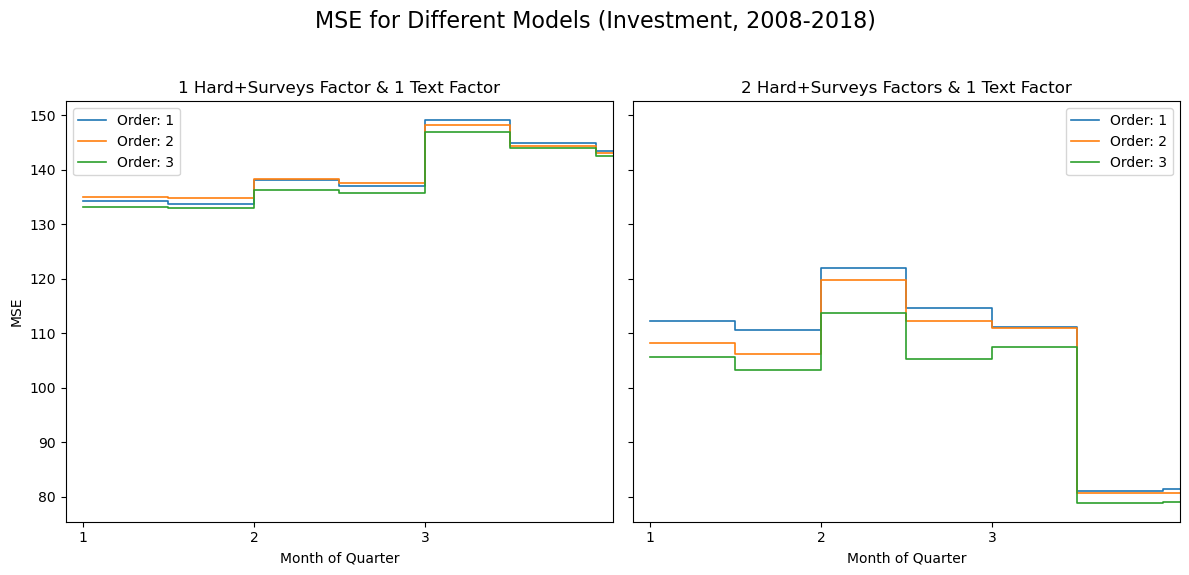

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'Investment'
text_type = "topics"
estimation_period = "2007"
num_topics = "200"
source = "all"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update"

# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Loop over the number of HardSurveys factors (1 or 2)
for i, num_factors in enumerate(range(1, 3)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"HS_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


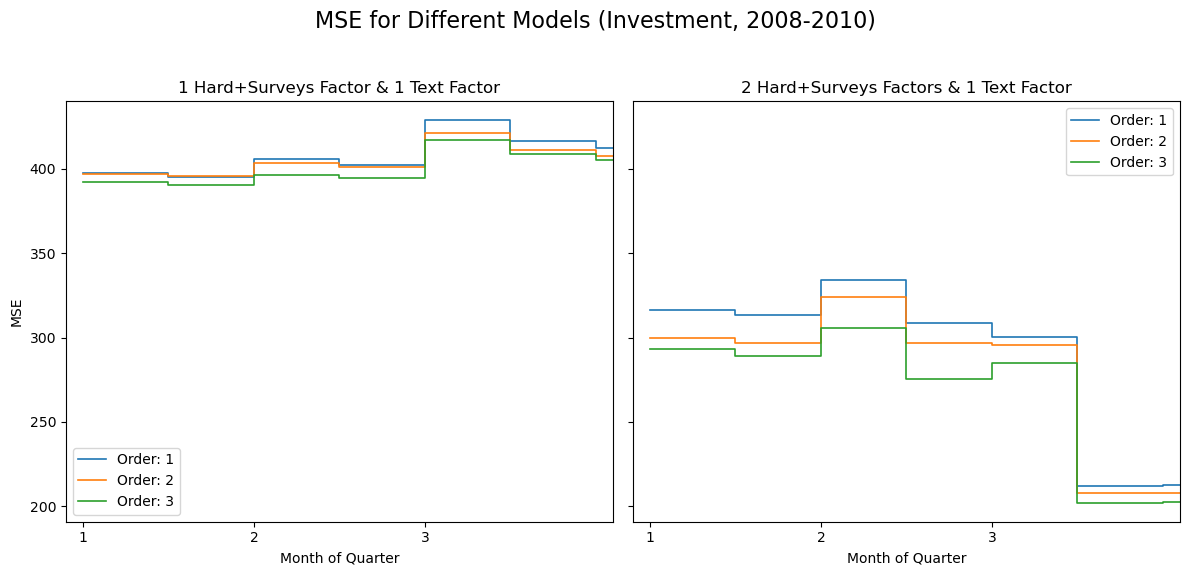

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


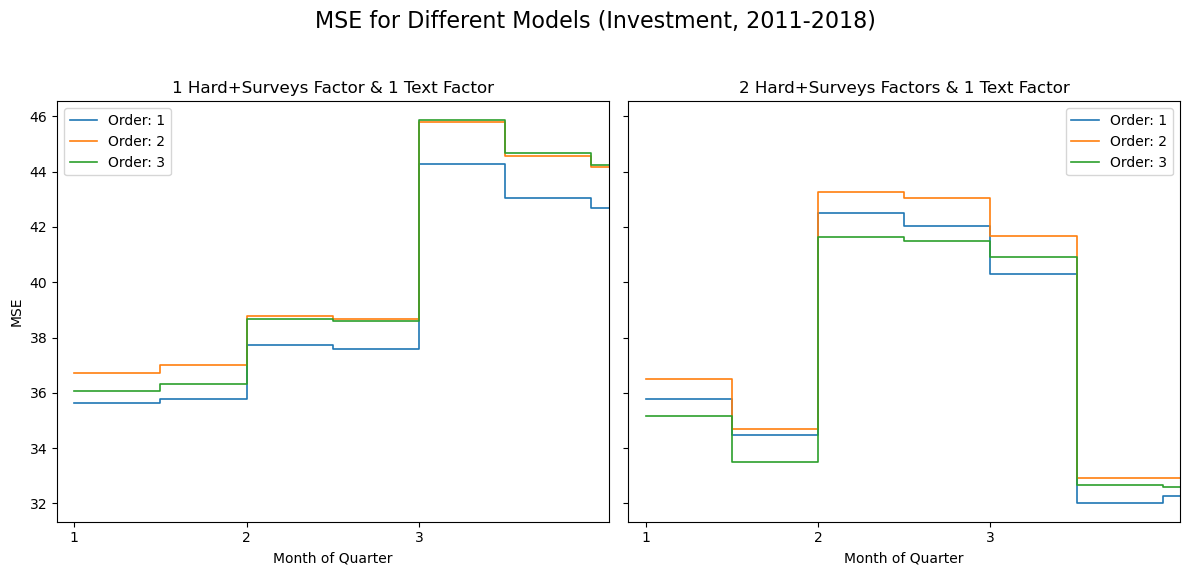

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Investment'
text_type = "topics"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update"
actual_growth_file = f"../{q_var}_growth_actual_update.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 2 columns of subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate(range(1, 3)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_Investment_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


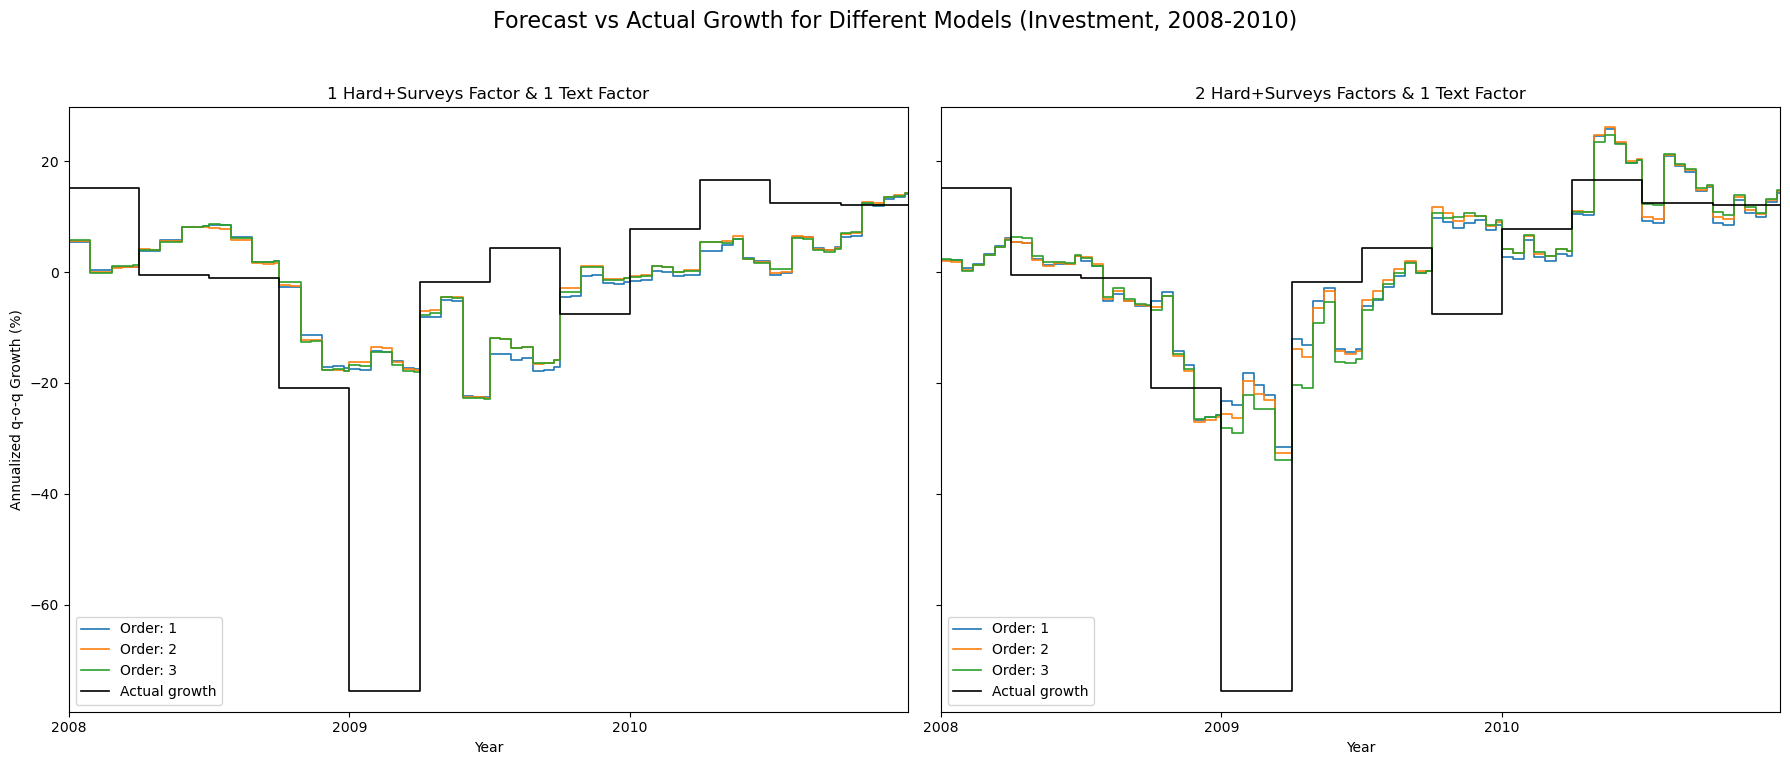

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


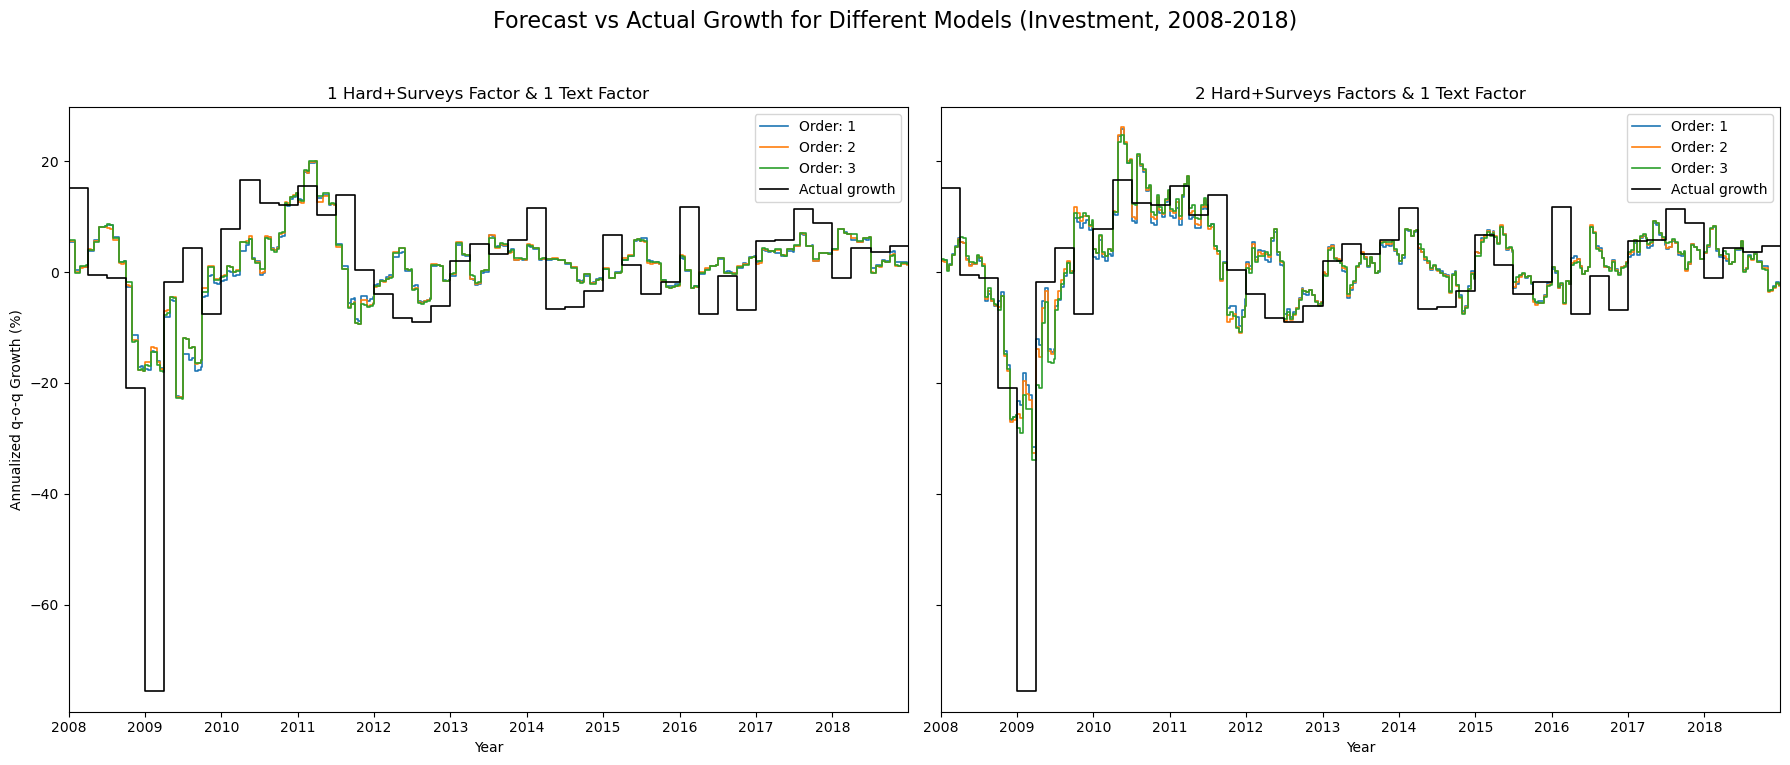

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


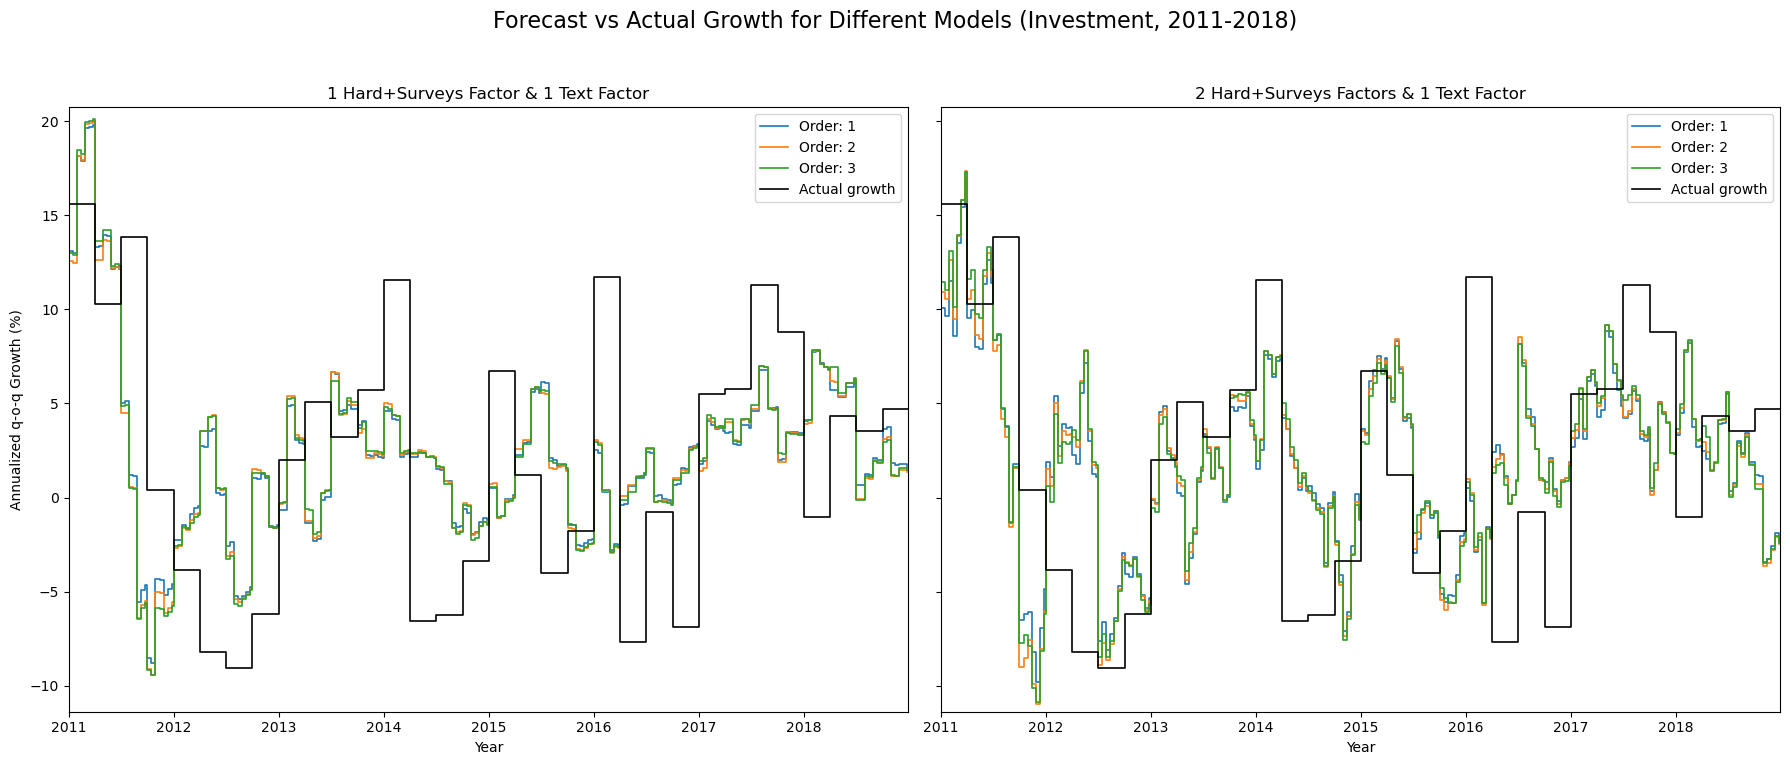

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Investment'
text_type = "topics"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update"
actual_growth_file = f"../{q_var}_growth_actual_update.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 2 columns for the two Hard+Surveys factor counts
    fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate([1, 2]):
        ax = axs[i]

        # For each HardSurveys factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_Investment_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}_update", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()